In [0]:
import keras
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [0]:
## [deskew]
SZ=28
affine_flags = cv2.WARP_INVERSE_MAP|cv2.INTER_LINEAR

def deskew(img):
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11']/m['mu02']
    M = np.float32([[1, skew, -0.5*SZ*skew], [0, 1, 0]])
    img = cv2.warpAffine(img,M,(SZ, SZ),flags=affine_flags)
    return img
## [deskew]

def showOpencvImage(image, isGray=False):
    fig = plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap = 'gray')
    plt.show()

(60000, 28, 28)
255
0


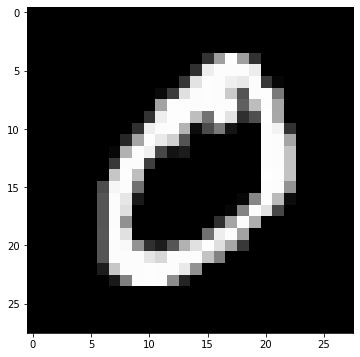

60000
[5 0 4 ... 5 6 8]
(10000, 28, 28)
[7 2 1 ... 4 5 6]


In [23]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

print(train_images.shape)

print(np.max(train_images[1]))
print(np.min(train_images[1]))

showOpencvImage(train_images[1])

print(len(train_labels))

print(train_labels)

print(test_images.shape)

print(test_labels)

without conversion: 
70000


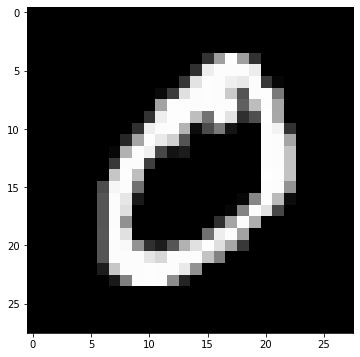

with conversion: 
70000


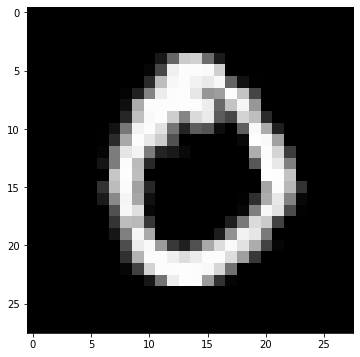

In [24]:
im_list = [train_images[i] for i in range(0,train_images.shape[0])] + [test_images[i] for i in range(0,test_images.shape[0])]

#train/test split with rotation conversion
train_deskewed = [deskew(im) for im in im_list[0:train_images.shape[0]]]
test_deskewed = [deskew(im) for im in im_list[train_images.shape[0]:]]
train_deskewed = np.asanyarray(train_deskewed)
test_deskewed = np.asanyarray(test_deskewed)
im_list2 = [train_deskewed[i] for i in range(0,train_deskewed.shape[0])] + [test_deskewed[i] for i in range(0,test_deskewed.shape[0])]


print("without conversion: ")
print(len(im_list))
showOpencvImage(train_images[1])
print("with conversion: ")
print(len(im_list2))
showOpencvImage(train_deskewed[1])

In [0]:
from keras import models
from keras import layers

#network for images without rotation conversion
networkv1 = models.Sequential()
networkv1.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
networkv1.add(layers.Dense(10, activation='softmax'))

networkv1.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

#network for images with roation conversion
networkv2 = models.Sequential()
networkv2.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
networkv2.add(layers.Dense(10, activation='softmax'))

networkv2.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [0]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

train_deskewed = train_deskewed.reshape((60000, 28 * 28))
train_deskewed = train_deskewed.astype('float32') / 255

test_deskewed = test_deskewed.reshape((10000, 28 * 28))
test_deskewed = test_deskewed.astype('float32') / 255


In [27]:
from keras.utils import to_categorical

encoded_train_labels = to_categorical(train_labels)
encoded_test_labels = to_categorical(test_labels)

encoded_test_labels

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
#without rotation 
networkv1.fit(train_images, encoded_train_labels, epochs=5, batch_size=128)

#with rotation
networkv2.fit(train_deskewed, encoded_train_labels, epochs=5, batch_size=128)







Epoch 1/5
60000/60000 [==============================] - 5s 86us/step - loss: 0.2596 - acc: 0.9246
Epoch 2/5
60000/60000 [==============================] - 5s 82us/step - loss: 0.1081 - acc: 0.9680
Epoch 3/5
60000/60000 [==============================] - 5s 84us/step - loss: 0.0726 - acc: 0.9785
Epoch 4/5
60000/60000 [==============================] - 5s 82us/step - loss: 0.0527 - acc: 0.9840
Epoch 5/5
60000/60000 [==============================] - 5s 82us/step - loss: 0.0409 - acc: 0.9881
Epoch 1/5
60000/60000 [==============================] - 5s 81us/step - loss: 0.2063 - acc: 0.9396
Epoch 2/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.0877 - acc: 0.9735
Epoch 3/5
60000/60000 [==============================] - 5s 81us/step - loss: 0.0601 - acc: 0.9814
Epoch 4/5
60000/60000 [==============================] - 5s 80us/step - loss: 0.0456 - acc: 0.9860
Epoch 5/5
60000/60000 [==============================] - 5s 79us/step - loss: 0.0357 - acc: 0.9891


[[3.1567325e-08 2.7762002e-08 5.3908661e-06 5.4016896e-03 1.7061804e-12
  1.3058956e-06 6.2224446e-15 9.9456704e-01 2.2066124e-06 2.2310624e-05]]
7


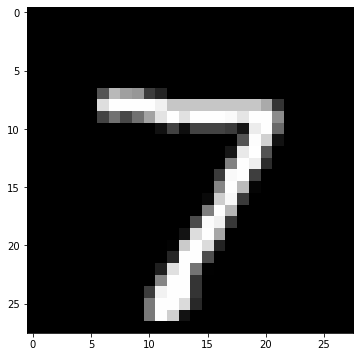

[[3.1567325e-08 2.7762002e-08 5.3908661e-06 5.4016896e-03 1.7061804e-12
  1.3058956e-06 6.2224446e-15 9.9456704e-01 2.2066124e-06 2.2310624e-05]]
7


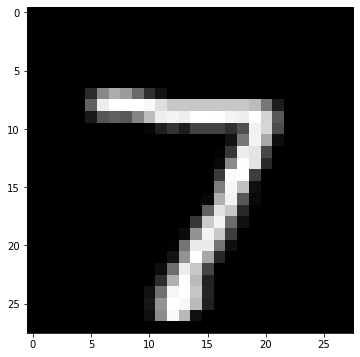

In [29]:
#without rotation
pred_probabilities1 = networkv1.predict(test_images)
print(pred_probabilities1[0:1])

pred_labels1 = np.argmax(pred_probabilities1,-1)
print(pred_labels1[0])
showOpencvImage(test_images[0].reshape(28,-1))

#with rotation
pred_probabilities2 = networkv2.predict(test_deskewed)
print(pred_probabilities1[0:1])

pred_labels2 = np.argmax(pred_probabilities2,-1)
print(pred_labels2[0])
showOpencvImage(test_deskewed[0].reshape(28,-1))

In [31]:
from sklearn.metrics import classification_report, confusion_matrix

#without rotation
print("without rotation conversion")
cm = confusion_matrix(test_labels, pred_labels1)
print(cm)
print(classification_report(test_labels, pred_labels1))

#with rotation
print("with rotation conversion")
cm = confusion_matrix(test_labels, pred_labels2)
print(cm)
print(classification_report(test_labels, pred_labels2))



without rotation conversion
[[ 968    1    0    1    0    1    4    1    2    2]
 [   0 1128    1    1    0    0    2    0    3    0]
 [   5    4 1000    2    1    1    2    4   13    0]
 [   0    0    3  985    0   10    0    3    5    4]
 [   3    2    1    1  954    1    7    3    2    8]
 [   2    0    0    2    0  884    1    0    2    1]
 [   5    3    0    1    1    9  936    0    3    0]
 [   0   12    6    5    1    1    0  987    8    8]
 [   1    0    3    4    1    7    0    1  954    3]
 [   1    7    0    4    4    8    1    4    5  975]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.97      0.99      0.98      1135
           2       0.99      0.97      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.96      0.99      0.97       892
           6       0.98      0.98      0.98       958
        